# Bin tag applier. 
This model implements the binary tagging model that was developed in notebook `/notebooks/machine learning notebooks/1 - usability tagger.ipynb`

Initially a single model was implemented without using a variable learning rate. The output of this model will be kept. There are three models (one model which was in there twice and has a sligthly lower treshold), which will be ran in this notebook. The cutoffpoint is not used to determine 1 or 0; in stead the certainty score will just be saved as a float - if needed, you can always change the way you query to get a higher or lower certainty. 

This shall be done for all three selected models. If need be, a boosting strategy can be applied later - but that's not within the current scope of the project. 

Data is stored in SQL so that we don't need to do the same constly computation over and over again (the first model needed 8 hours to process the whole dataset. I dread to imagine how long this will take.)

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import sys
import re
from tqdm import tqdm


sys.path.append('../../utils')
import config_handling as conf
from database import Database
from file_io import path_handler
import cnn_helpers

2025-02-09 09:42:07.074210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load configuration
config = conf.read_config('../../config/automotive.conf.ini')
config.read('config.ini')
connection_type = config['settings']['connection']
user = config[connection_type]['user']
pw = config[connection_type]['pw']
host = config[connection_type]['host']
db = config[connection_type]['db']
port = config[connection_type].getint('port')
db = Database(host,
              port,
              user,
              pw,
              db
              )
db.connect()

# Image directory
basedir = config['settings']['image_directory']

Connection established


In [3]:
#model1 was found using a static LR in a grid of 0.01. It's not concidered a serious contender at the moment. 
#  best_model-Epochs=5-raster=64-bbox=True.keras 
#   Epochs = 5
#   gridsize = 64
#   BBOX = True         
#Notice that having a variable learning rate to test for in a grid, came up with a bunch of models that are all better than models with LR 0.01 AND BBOX=True
table_query = """CREATE TABLE IF NOT EXISTS bintag_predicts (
    image_id INT PRIMARY KEY,
    model1_results FLOAT, 
    model2_results FLOAT, 
    model3_results FLOAT,
    model4_results FLOAT
);"""
db.execute_query(table_query)
#Model 2,3,4 will just follow the order of the dumped CSV file in bintag/models 

[]

In [4]:
batch_size = 5000

In [5]:
img_query = "SELECT * FROM images;"
img_table = pd.DataFrame(db.execute_query(img_query))

In [6]:
print(len(img_table))

15647260


In [7]:
cnn_helpers.system_override()
device = cnn_helpers.system_pick_device()

System override applied - check if GPU is detected
Using GPU for deep learning.


2025-02-09 09:44:11.392491: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-09 09:44:13.985726: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-09 09:44:13.985791: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
img_table = img_table.fillna(-1)
img_table[['yolobox_top_left_x', 'yolobox_top_left_y', 'yolobox_bottom_right_x', 'yolobox_bottom_right_y']] = img_table[['yolobox_top_left_x', 'yolobox_top_left_y', 'yolobox_bottom_right_x', 'yolobox_bottom_right_y']].astype(int)
img_table['image_path'] = img_table['image_path'].apply(lambda x: path_handler(basedir, x))

/tmp/ipykernel_988794/3323961686.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  img_table = img_table.fillna(-1)


In [9]:
img_table.sample(5)

,id,listing_id,processed,use_image,certainty_of_outside_yolo,yolobox_top_left_x,yolobox_top_left_y,yolobox_bottom_right_x,yolobox_bottom_right_y,area,confidence,image_path
10992392,11652668,678454,1,1,-1,79,109,677,446,0.478032,0.90815,/home/frederic/Documents/automotive_image_data...
12875044,13535320,748795,1,0,-1,-1,-1,-1,-1,-1.000000,-1.00000,/home/frederic/Documents/automotive_image_data...
8900565,9560841,579546,1,0,-1,-1,-1,-1,-1,-1.000000,-1.00000,/home/frederic/Documents/automotive_image_data...
2071833,2321518,147371,1,0,-1,-1,-1,-1,-1,-1.000000,-1.00000,/home/frederic/Documents/automotive_image_data...
7677408,8337684,504284,1,1,-1,1,4,750,476,0.839357,0.76246,/home/frederic/Documents/automotive_image_data...


In [10]:
#use_bbox = True
#rastersize = 64
#name = 'best_model-Epochs=5-raster=64-bbox=True.keras'
#model_dir = os.path.join(os.getcwd(), '../../models/bin_models')
#model = load_model(os.path.join(model_dir, name))

In [11]:
# it does not matter that we lose the data here for one treshold; this is a documented decision, it can be retrieved from the .csv file.
models = pd.read_csv('../../models/bin_models/chosen_models.csv')
models = models.drop_duplicates(subset=['BBOX', 'Rastersize', 'Epochs', 'Learningrate'])
models


,Treshold,BBOX,Rastersize,Epochs,Learningrate,Fractionsize,True_Negatives,True_Positives,False_Negatives,False_Positives,Precision,Recall,F1,FPR,TNR
0,0.75,False,128,20,0.0001,1.0,2464,1258,214,64,0.951589,0.854620,0.900501,0.025316,0.974684
1,0.50,False,128,10,0.0001,1.0,2401,1380,92,127,0.915727,0.937500,0.926485,0.050237,0.949763
2,0.90,False,64,5,0.0010,1.0,2447,1312,160,81,0.941852,0.891304,0.915881,0.032041,0.967959


In [25]:
models_to_columns = []
for idx, modelrow in models.iterrows():

    use_bbox = modelrow['BBOX']
    rastersize = modelrow['Rastersize']
    epochs = modelrow['Epochs']
    lr = modelrow['Learningrate']
    modelname = f'selected_model---Epochs={epochs}-raster={rastersize}-bbox={use_bbox}-learningrate={lr}.keras'
    model_dir = os.path.join(os.getcwd(), '../../models/bin_models')
    sql_col_name = f"model{idx+2}_results"  #+2 because model1 is used from earlier attempt (let's keep the result)
    models_to_columns.append([modelname, sql_col_name])
    #check if this columns is comlete or not, if it is, skip it: 
    completeness_query = f"select count(*) as remaining from bintag_predicts where {sql_col_name} is null"
    remaining = db.execute_query(completeness_query)
    if remaining[0]['remaining'] == 0: 
        print('SKIPPING (collumn completed) ', modelname, ' into ', sql_col_name)
        continue
    print('loading ', modelname, ' into ', sql_col_name)
    model = load_model(os.path.join(model_dir, modelname))
    completed_images = f"select image_id from bintag_predicts where {sql_col_name}  is not null;"
    done = db.execute_query(completed_images)
    completed = [x['image_id'] for x in done]
    for start in range(0, len(img_table), batch_size): 
        batch = img_table.iloc[start:start + batch_size]
        images = []
        pk_ids = batch['id']
        if bool(completed): 
            if max(pk_ids) < max(completed)-batch_size:
                continue
        for _, row in batch.iterrows():
            bbox = (row['yolobox_top_left_x'], row['yolobox_top_left_y'], row['yolobox_bottom_right_x'], row['yolobox_bottom_right_y'])
            img = cnn_helpers.preprocess_image(row['image_path'], use_bbox, bbox, rastersize)
            images.append(img)
        images = np.array(images)
        predictions = model.predict(images)
        batch_df = pd.DataFrame({
            'id' : pk_ids.values, 
            'predictions' : predictions.flatten()
        })
        update_query = f"""UPDATE bintag_predicts set {sql_col_name} = %s WHERE image_id = %s """
        for _, row in batch_df.iterrows(): 
            db.execute_query(update_query, [row['predictions'], row['id']])

        # Commit and close connection
        db.commit_transaction()
mod_cols = pd.DataFrame(models_to_columns)

SKIPPING (collumn completed)  selected_model---Epochs=20-raster=128-bbox=False-learningrate=0.0001.keras  into  model2_results
SKIPPING (collumn completed)  selected_model---Epochs=10-raster=128-bbox=False-learningrate=0.0001.keras  into  model3_results
loading  selected_model---Epochs=5-raster=64-bbox=False-learningrate=0.001.keras  into  model4_results
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [13]:
mod_cols

,0,1
0,selected_model---Epochs=20-raster=128-bbox=Fal...,model2_results
1,selected_model---Epochs=10-raster=128-bbox=Fal...,model3_results
2,selected_model---Epochs=5-raster=64-bbox=False...,model4_results


In [26]:
#check how good your predictions are by inspecting a random grid of results: 
#SMALL NOTICE: There's a big chance that 

query = """SELECT * 
        FROM images 
        JOIN bintag_predicts 
            ON bintag_predicts.image_id = images.id
        WHERE 
            bintag_predicts.model1_results >= 0.90
        ORDER BY RAND()
        LIMIT 10000

        """

prediction_data = pd.DataFrame(db.execute_query(query))
prediction_data['image_path'] = prediction_data['image_path'].apply(lambda x: path_handler(basedir, x))


Error executing query: (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'ORDER BY RAND()' at line 8")


KeyError: 'image_path'

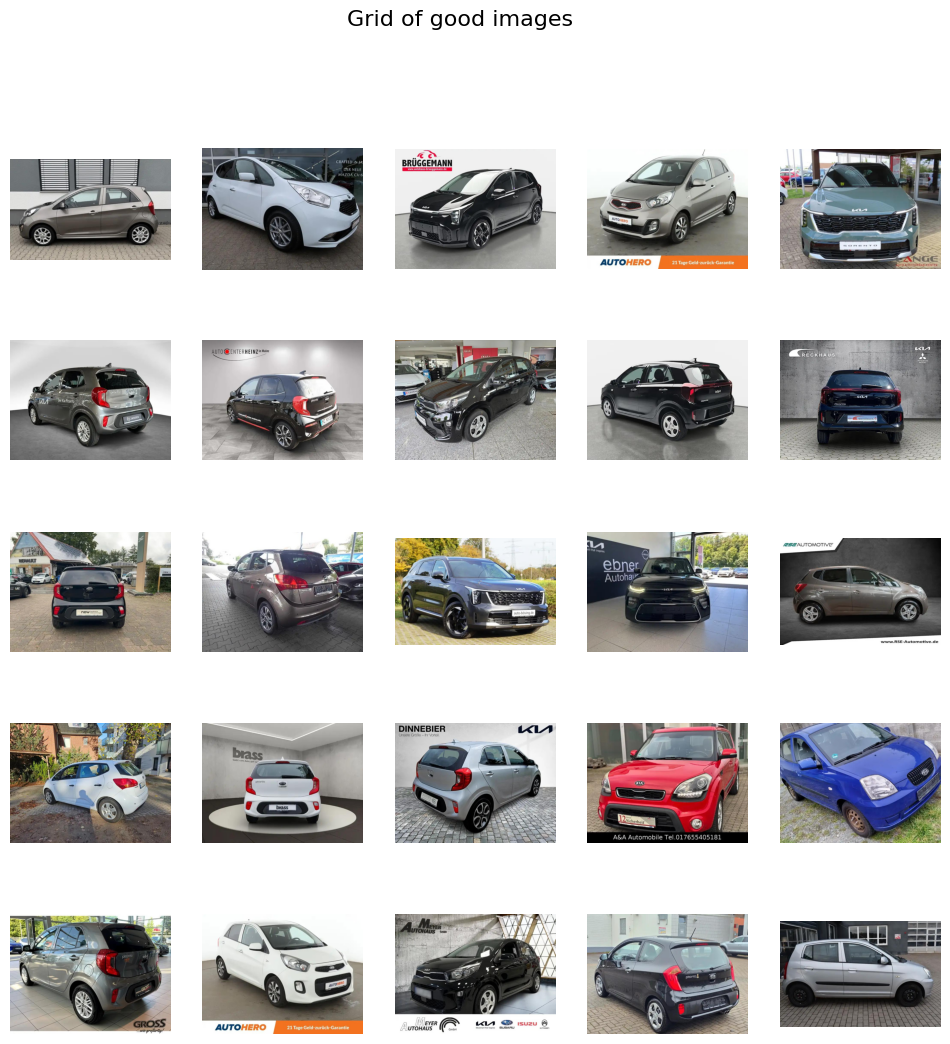

In [17]:
import matplotlib.pyplot as plt

def plot_images_as_grid(imseries, title, n=4): 
    """
    #TODO make this into utility
    creates a grid of n*n images by randomply picking n**2 images
    from a series object (imseries) and plots them into the notebook. 
    """
    samplesize = n**2
    chosen = imseries.sample(samplesize)
    fig, axes = plt.subplots(n, n, figsize=(12, 12))
    axes = axes.flatten()
    i = 0
    for image in chosen: 
        img = Image.open(image)
        axes[i].imshow(img)
        axes[i].axis('off')
        i+=1
    fig.suptitle(title, fontsize=16)

plot_images_as_grid(prediction_data['image_path'], 'Grid of good images',5)


In [ ]:
#habemus etwuk da marcheert! kzien content

SELECT
    block_start,
    COUNT(*) AS f
FROM (
    SELECT
        FLOOR(model1_results / 0.01) * 0.01 AS block_start
    FROM bintag_predicts
    WHERE model1_results >= 0 AND model1_results < 1
) AS subquery
GROUP BY block_start
ORDER BY block_start;
